In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from category_encoders import BinaryEncoder, CountEncoder, OrdinalEncoder

In [246]:
base = './bitrate_prediction/'

In [247]:
df = pd.read_csv(base + 'bitrate_train.csv')

In [249]:
def _check_nans(df):
    """returns num of empty items in a dataframe"""
    return df.isna().sum().sum()

In [250]:
_check_nans(df)

0

In [251]:
"Total duplicated samples: ", df.duplicated().sum()

('Total duplicated samples: ', 3361)

In [252]:
TARGET = 'target'

In [253]:
print("Total no. of columns in dataset: %d" % len(df.columns.tolist()))

Total no. of columns in dataset: 10


In [254]:
# checking for NaN values in individual columns

cat_cols = []

for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} has NA: ", pd.isna(df[col].sum()))
        cat_cols.append(col)
    elif df[col].dtype == np.int64:
        print(f"{col} has NA: ", (df[col] == 0).sum())
    else:
        print(f"{col} has NA: ", (df[col] == 0.0).sum())


fps_mean has NA:  0
fps_std has NA:  92611
rtt_mean has NA:  5496
rtt_std has NA:  15520
dropped_frames_mean has NA:  368604
dropped_frames_std has NA:  368750
dropped_frames_max has NA:  368604
bitrate_mean has NA:  290
bitrate_std has NA:  4511
target has NA:  320


In [255]:
cat_cols  # we have no categorical columns

[]

<Figure size 800x600 with 0 Axes>

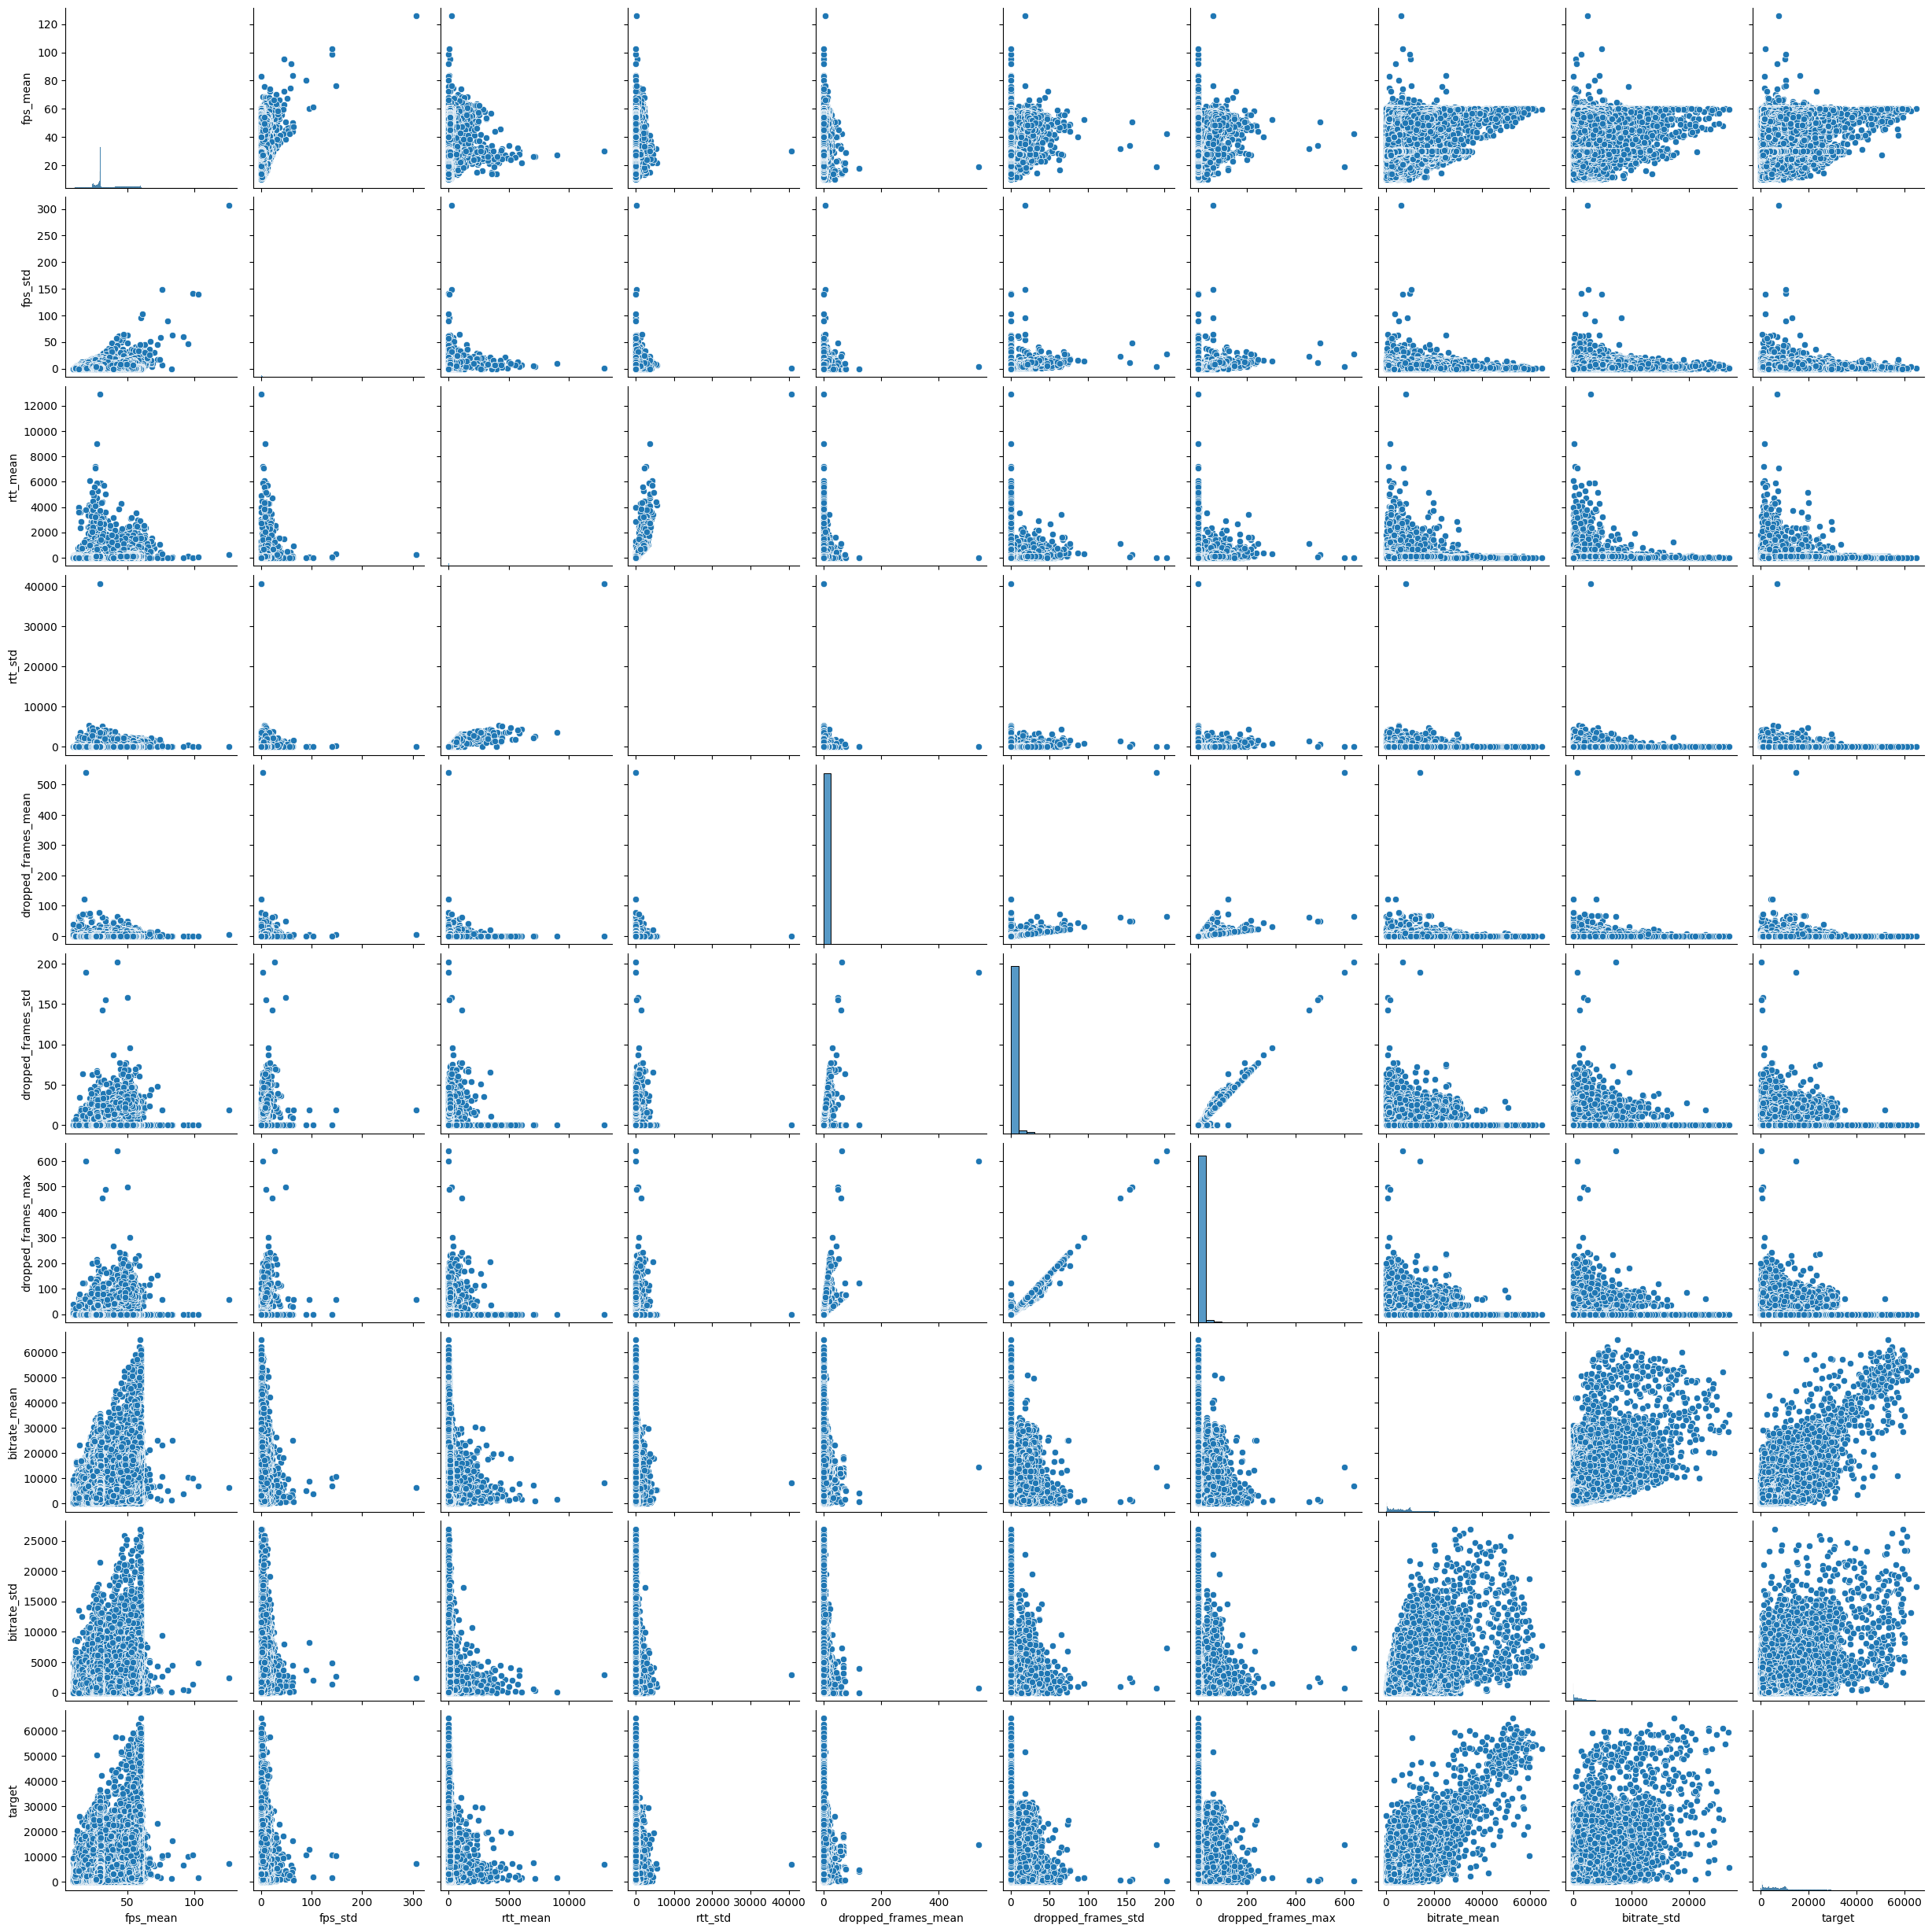

In [13]:
%matplotlib inline

plt.figure(figsize = (8, 6))
sns.pairplot(df)
plt.show()

In [15]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [25]:
profile.to_file(base + "eda_regression.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5215: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
profile.to_notebook_iframe()

In [256]:
# dropped_frames_mean (v 3.0) (std [v 9.9] /max [v 93.52])  =>  
# bitrate_mean (var 36893381.11) (bitrate_std) (var 2961915.42) =>  
# rtt_mean (var 8983.45)  (rtt_std) (var 12697.78)  =>  
# fps_mean (var 1200.45) (fps_std) (var 6.27) =>  


selected_cols = ['dropped_frames_max', 'bitrate_mean', 'rtt_std', 'fps_mean', TARGET] 

In [257]:
print(', '.join(list(map(lambda x: x.replace('_', '\_'), selected_cols))))

dropped\_frames\_max, bitrate\_mean, rtt\_std, fps\_mean, target


In [258]:
df = df[selected_cols]

In [259]:
df.describe()

dropped_frames_max   bitrate_mean        rtt_std       fps_mean  \
count       379021.000000  379021.000000  379021.000000  379021.000000   
mean             1.450719    7516.585502      12.763672      35.231127   
std              9.670928    6073.992189     112.684460      10.975010   
min              0.000000       0.000000       0.000000      10.000000   
25%              0.000000    2773.300000       0.699206      28.800000   
50%              0.000000    6287.200000       1.433721      30.000000   
75%              0.000000   10187.200000       4.948625      43.600000   
max            640.000000   64913.500000   40721.933293     125.800000   

              target  
count  379021.000000  
mean     7525.396231  
std      6070.817736  
min         0.000000  
25%      2785.000000  
50%      6296.000000  
75%     10192.000000  
max     64913.000000

## Outliner Detection

In [87]:
df['bitrate_mean'].values.std()

6073.984175939827

<AxesSubplot:>

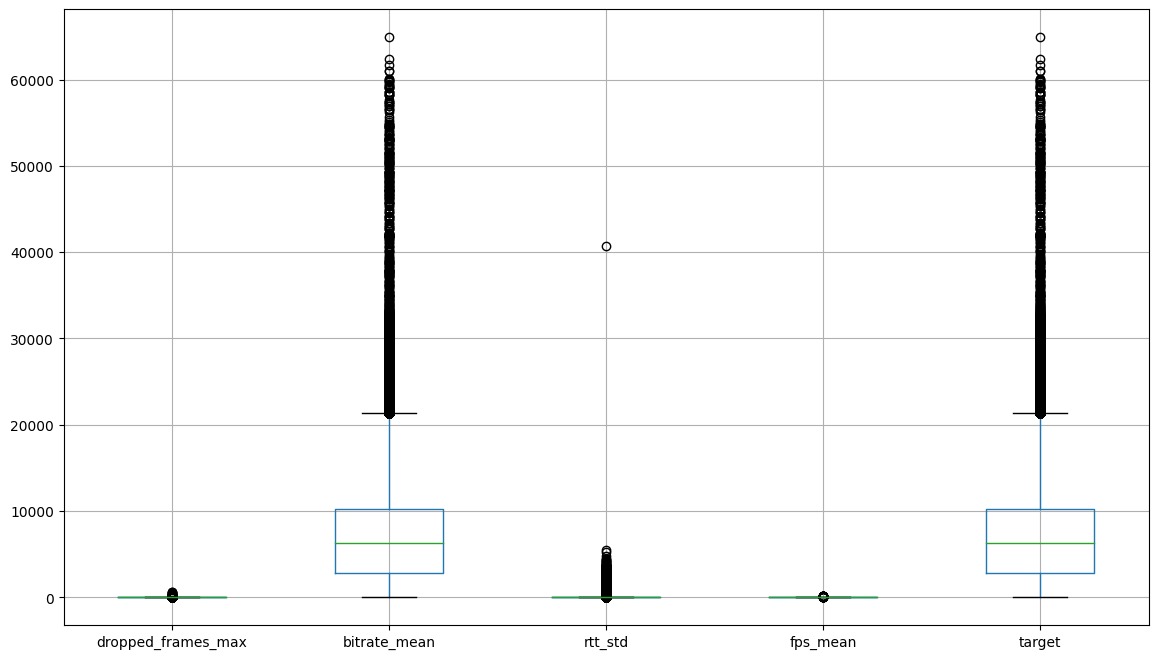

In [25]:
df.boxplot(figsize = (14, 8))

In [171]:
df.drop(3, axis=0) #.loc[3]

dropped_frames_max  bitrate_mean     rtt_std  fps_mean  target
0                      0.0         460.5    6.723921      24.4   616.0
1                      0.0         616.3   15.923777      28.6   565.0
2                      0.0         565.2   11.798776      30.0   573.0
4                      0.0         585.8   62.476307      29.9   555.0
5                      0.0         555.2  114.257798      29.5   456.0
...                    ...           ...         ...       ...     ...
379016                 0.0        3324.9    0.000000      40.0  3325.0
379017                 0.0        3325.3    0.000000      40.0  3293.0
379018                 0.0        3293.2    0.000000      40.0  3317.0
379019                 0.0        3317.0    0.000000      40.0  3283.0
379020                 0.0        3283.2    0.000000      40.0  3314.0

[379020 rows x 5 columns]

In [183]:
def compute_IQR(df_iqr):
    df = df_iqr.drop(TARGET, axis=1)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    df_wo_outliers = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))].dropna(how='all')
    df_wo_outliers[TARGET] = df_iqr.loc[df_wo_outliers.index][TARGET]
    return df_wo_outliers

In [184]:
df.loc[compute_IQR(df).index]

dropped_frames_max       0.000000
bitrate_mean          7413.900000
rtt_std                  4.249419
fps_mean                14.800000
dtype: float64


dropped_frames_max  bitrate_mean     rtt_std  fps_mean   target
1                      0.0         616.3   15.923777      28.6    565.0
2                      0.0         565.2   11.798776      30.0    573.0
3                      0.0         573.8   13.014522      30.3    585.0
4                      0.0         585.8   62.476307      29.9    555.0
5                      0.0         555.2  114.257798      29.5    456.0
...                    ...           ...         ...       ...      ...
378997                78.0       16848.4    0.527046      48.4  15492.0
379004                 0.0       18732.2   12.167352      53.2  17995.0
379005                85.0       17995.1    0.674949      48.3  15244.0
379006                68.0       15244.2    0.788811      48.7  17195.0
379009                 0.0       12438.1   37.739458      44.9   3296.0

[69572 rows x 5 columns]

In [185]:
from sklearn.impute import SimpleImputer

def impute_data(df):
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(df)
    temp_df = pd.DataFrame(imputer.transform(df), columns=df.columns)
    return imputer, temp_df

In [186]:
imputer, df_imp = impute_data(compute_IQR(df))

dropped_frames_max       0.000000
bitrate_mean          7413.900000
rtt_std                  4.249419
fps_mean                14.800000
dtype: float64


In [187]:
imputer, df_imp

(SimpleImputer(),
        dropped_frames_max  bitrate_mean     rtt_std   fps_mean   target
 0               52.784199  25913.967573   15.923777  77.657692    565.0
 1               52.784199  25913.967573   11.798776  77.657692    573.0
 2               52.784199  25913.967573   13.014522  77.657692    585.0
 3               52.784199  25913.967573   62.476307  77.657692    555.0
 4               52.784199  25913.967573  114.257798  77.657692    456.0
 ...                   ...           ...         ...        ...      ...
 69567           78.000000  25913.967573   77.396925  77.657692  15492.0
 69568           52.784199  25913.967573   12.167352  77.657692  17995.0
 69569           85.000000  25913.967573   77.396925  77.657692  15244.0
 69570           68.000000  25913.967573   77.396925  77.657692  17195.0
 69571           52.784199  25913.967573   37.739458  77.657692   3296.0
 
 [69572 rows x 5 columns])

In [193]:
# checking for NaNs in the columns
for col in df_imp.columns:
    print(f'{col}: ', df_imp[col].isna().sum())

dropped_frames_max:  0
bitrate_mean:  0
rtt_std:  0
fps_mean:  0
target:  0


/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bitrate_mean', ylabel='Density'>

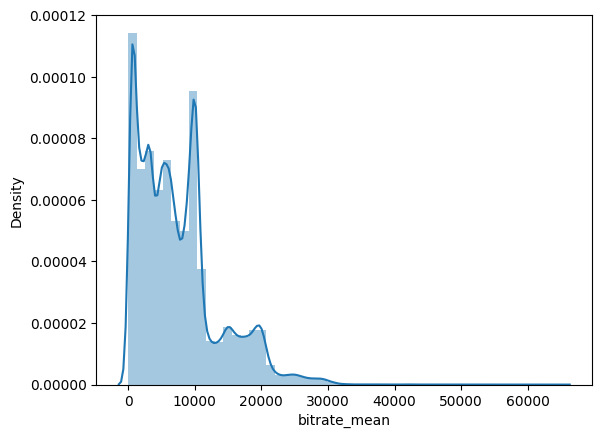

In [28]:
sns.distplot(df['bitrate_mean'])

In [29]:
df['bitrate_mean']

0          460.5
1          616.3
2          565.2
3          573.8
4          585.8
           ...  
379016    3324.9
379017    3325.3
379018    3293.2
379019    3317.0
379020    3283.2
Name: bitrate_mean, Length: 379021, dtype: float64

### Scaling Data

In [260]:
from sklearn.preprocessing import RobustScaler, StandardScaler

def scale_data(df_selected, scaler = None, y_col = 'stream_quality'):
    
    if not scaler:
        scaler = StandardScaler()
    df_selected_without_y = df_selected.drop(y_col, axis=1)
    scaler.fit(df_selected_without_y)
    data_scaled = scaler.transform(df_selected_without_y)
    df_scaled = pd.DataFrame(data_scaled, columns = df_selected_without_y.columns)
    df_scaled[y_col] = df_selected[y_col]
    return scaler, df_scaled

In [261]:
scaler, df_scaled = scale_data(df, y_col = TARGET)
df_scaled

dropped_frames_max  bitrate_mean   rtt_std  fps_mean  target
0                -0.150008     -1.161690 -0.053599 -0.986891   616.0
1                -0.150008     -1.136039  0.028044 -0.604203   565.0
2                -0.150008     -1.144452 -0.008563 -0.476640   573.0
3                -0.150008     -1.143036  0.002226 -0.449306   585.0
4                -0.150008     -1.141061  0.441167 -0.485752   555.0
...                    ...           ...       ...       ...     ...
379016           -0.150008     -0.690105 -0.113269  0.434522  3325.0
379017           -0.150008     -0.690039 -0.113269  0.434522  3293.0
379018           -0.150008     -0.695324 -0.113269  0.434522  3317.0
379019           -0.150008     -0.691405 -0.113269  0.434522  3283.0
379020           -0.150008     -0.696970 -0.113269  0.434522  3314.0

[379021 rows x 5 columns]

In [262]:
from sklearn.model_selection import train_test_split

def split_data(data, target = 'stream_quality', test_sz = 0.2):
    df_train, df_val, = train_test_split(data, test_size=test_sz, random_state=0)
    print(df_train.shape, df_val.shape)
    return df_train, df_val

In [263]:
df_train, df_val = split_data(df_scaled, target=TARGET)

(303216, 5) (75805, 5)


### PCA

In [61]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=2)
pca

PCA(n_components=2)

In [83]:
X = pca.fit_transform(df_train.drop(TARGET, axis=1))

/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

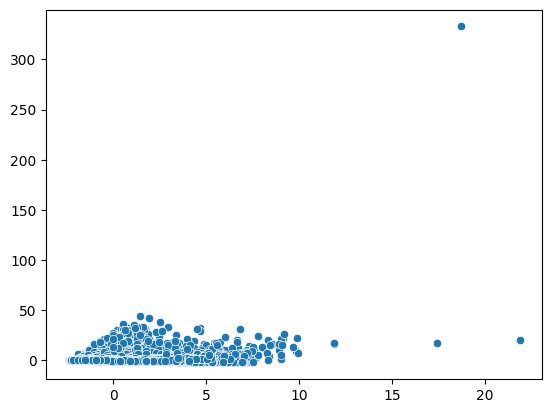

In [84]:
sns.scatterplot(X[:, 0], X[:, 1])

In [264]:
df_test = pd.read_csv(base + 'bitrate_test.csv', usecols=selected_cols)

In [265]:
_, df_test_scaled = scale_data(df_test, scaler=scaler, y_col = TARGET)


### Regression Model

In [266]:
from sklearn.linear_model import LinearRegression

In [267]:
lr_clf = LinearRegression()
lr_clf.fit(df_train.drop(TARGET, axis=1), df_train[TARGET])

LinearRegression()

In [268]:
lr_clf.score(df_val.drop(TARGET, axis=1), df_val[TARGET])

0.8948075394037492

In [269]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def print_eval_metrics(y_pred, y_true):
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("MSE: ", round(mse, 2))
    print("MAE: ", round(mae, 2))
    print("R2: ", round(r2, 2))

In [270]:
print_eval_metrics(lr_clf.predict(df_val.drop(TARGET, axis=1)), df_val[TARGET])

MSE:  3887643.53
MAE:  1098.52
R2:  0.89


In [271]:
len(df_test.columns)

5

In [272]:
print_eval_metrics(lr_clf.predict(df_test_scaled.drop(TARGET, axis=1)), df_test_scaled[TARGET])

MSE:  70765149.55
MAE:  4994.07
R2:  -0.98


/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Lasso

In [274]:
from sklearn.linear_model import Lasso

lasso = Lasso(0.5)
lasso.fit(df_train.drop(TARGET, axis=1), df_train[TARGET])
lasso.score(df_val.drop(TARGET, axis=1), df_val[TARGET])

0.8948069226911273

In [275]:
# print_eval_metrics(lasso.predict(df_val.drop(TARGET, axis=1)), df_val[TARGET])
print_eval_metrics(lasso.predict(df_test.drop(TARGET, axis=1)), df_test[TARGET])

MSE:  390576160737.57
MAE:  315762.32
R2:  -10951.57


/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Ridge

In [276]:
from sklearn.linear_model import Ridge

ridge = Ridge(0.2)
ridge.fit(X, df_train[TARGET])
ridge.score(pca.transform(df_val.drop(TARGET, axis=1)), df_val[TARGET])

0.504197725638033

In [279]:
print_eval_metrics(ridge.predict(pca.transform(df_test_scaled.drop(TARGET, axis=1))), df_test_scaled[TARGET])

MSE:  20853253.35
MAE:  3057.05
R2:  0.42


/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [284]:
!xdg-open .

### Polynomial Regression 

In [280]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(5)
X_pol = poly.fit_transform(df_train.drop(TARGET, axis=1))
X_pol.shape

(303216, 126)

In [281]:
df_train.shape

(303216, 5)

In [282]:
from sklearn.linear_model import Lasso

lasso = Lasso(0.2)
lasso.fit(X_pol, df_train[TARGET])
lasso.score(poly.transform(df_test_scaled.drop(TARGET, axis=1)), df_test_scaled[TARGET])

/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.944e+11, tolerance: 1.117e+09
  model = cd_fast.enet_coordinate_descent(
/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


-70624.13572637778

In [283]:
print_eval_metrics(lasso.predict(poly.transform(df_test_scaled.drop(TARGET, axis=1))), df_test_scaled[TARGET])

/media/symlink_part/.virtualenvs/ml_assg1/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


MSE:  2518539973833.82
MAE:  26007.75
R2:  -70624.14


### Regression after Outlier Removal using IQR

In [188]:
scaler_imp, df_scaled_imp = scale_data(df_imp, y_col = TARGET)
df_scaled_imp

dropped_frames_max  bitrate_mean   rtt_std      fps_mean   target
0            6.973619e-16           0.0 -0.240351  5.166886e-14    565.0
1            6.973619e-16           0.0 -0.256480  5.166886e-14    573.0
2            6.973619e-16           0.0 -0.251726  5.166886e-14    585.0
3            6.973619e-16           0.0 -0.058338  5.166886e-14    555.0
4            6.973619e-16           0.0  0.144121  5.166886e-14    456.0
...                   ...           ...       ...           ...      ...
69567        2.474804e+00           0.0  0.000000  5.166886e-14  15492.0
69568        6.973619e-16           0.0 -0.255038  5.166886e-14  17995.0
69569        3.161819e+00           0.0  0.000000  5.166886e-14  15244.0
69570        1.493354e+00           0.0  0.000000  5.166886e-14  17195.0
69571        6.973619e-16           0.0 -0.155055  5.166886e-14   3296.0

[69572 rows x 5 columns]

In [194]:
df_train_imp, df_val_imp = split_data(df_scaled_imp, target = TARGET, test_sz = 0.2)

(55657, 5) (13915, 5)


In [197]:
from sklearn.linear_model import Ridge

ridge = Ridge(0.5)
ridge.fit(df_train_imp.drop(TARGET, axis=1), df_train_imp[TARGET])
ridge.score(df_val_imp.drop(TARGET, axis=1), df_val_imp[TARGET])

0.03729757344586404

In [234]:
print_eval_metrics(ridge.predict(df_val_imp.drop(TARGET, axis=1)), df_val_imp[TARGET])

MSE:  85617953.32
MAE:  6632.59
R2:  -0.21
